# Denoising the denoising: interpreting the "non-agressive" or "soft" ICA denoising strategy

Independent Component Analysis (ICA) has been a popular method for denoising fMRI data. A number of methods have ben recently proposed to automatically classify ICA components as "signal" or "noise". Two most popular methods - AROMA and FIX use the FSL tool fsl_regfilt to remove the "noise" components via regression.

There are two strategies for performing the denoising. One is called "agressive" and the other is called "non-agressive". 

This topic has been covered in the literature in the past few years. In the Resting-state fMRI in the Human Connectome Project ([Smith et al. 2013](http://sci-hub.cc/10.1016/j.neuroimage.2013.05.039)) we read (emphasis added):
> For both volume and surface cleanup,the cleanup is done in a “non-aggressive” manner — both the good and bad component timeseries are regressed into the data, and then the resulting bad spatial maps are multiplied by the associated timeseries and subtracted from the original dataset. Thus, in this non-aggressive approach, **only the unique variance associated with the bad components is removed from the data**. Applying “aggressive” cleanup means removing all variance associated with the bad compo-nents, and not just the unique part, relative to non-artefact component timeseries.

This is how the two schemes are discribed in FIX paper ([Griffanti et al. 2014](http://sci-hub.cc/10.1016/j.neuroimage.2014.03.034) - emphasis added):

>The “aggressive” approach consisted of regression of the full space ofall artefacts (noise components) and the motion confounds out of the4D pre-processed data (Y), using:
>
> $Y_{clean} = Y-C\cdot{(pinv(C)\cdot{Y})}$
>
>where C is the matrix of artefact and motion time series ($C=[C_{motion}ICA(bad)]$) and $pinv()$ is the matrix pseudo-inverse (for example, asestimated via $pinv(C)=(C^TC)^{−1}C^T)$. With this method, the contribution of the motion and the artefacts is fully removed from the data. In general, the signal and noise ICA components are not completely orthogonal; this approach removes all shared variance between the two (hence the term “aggressive”).The “soft”, less aggressive, approach consisted of three steps. First, we regressed out the full space of the motion confounds ($C_motion$) from both the data and from all the (“good” and “bad”) ICA component time series (ICA), in order to fully (aggressively) remove the effect of motion from the data (resulting in $Y_m$) and the ICA timeseries (resulting in $ICA_m$):
>
> $Y_m = Y - C_{motion}\cdot{(pinv(C_{motion})\cdot{Y})}$
>
> $ICA_m = Y - C_{motion}\cdot{(pinv(C_{motion})\cdot{ICA})}$
>
>Second, we estimated the contribution of both good and bad components ($\widehat{\beta_{ICA}}$) via multiple regression of the data against all (motion-cleaned) ICA time series, in order to be able to identify the **unique variance of the artefacts** 
>
>$\widehat{\beta_{ICA}} = pinv(ICA_{m}\cdot{Y_m}$
>
>Finally, using this, the unique contribution of the bad componentswas removed from the data, utilising only the bad ICA components'time series and regression coefficients:
>
>$Y_{clean}= Y_m−ICA_m(bad)\cdot{\widehat{\beta_{ICA}}(bad)}$

In the AROMA paper ([Pruim et al. 2015](https://doi.org/10.1016/j.neuroimage.2015.02.064)) we read (emphasis added):

>ICs can be fully regressed out ofthe data, analogous to RP-regression (Friston et al., 1996; Satterthwaiteet al., 2013a). In this case, all variance associated with these noise ICs will be removed, including shared-variance with ‘good’ ICs. Therefore, such a component regression method can be regarded as ‘aggressive denoising’. Alternatively, one can employ a linear regression on the full mixing matrix as estimated by ICA, containing both signal andnoise ICs (see Section 'Step 3 - data denoising'). This allows **specifically removing the variance assigned to the identified noise ICs**, yielding ‘non-aggressive denoising’.

Finally in the recent book "Introduction to Resting State fMRI Functional Connectivity" we read (emphasis added):

> Once the components have all been labeled as either signal or noise, the last step is to perform a regression analysis to remove the variance associated with the components labeled as noise from the data. There are two options for removing the noise ICA components from the data, and they are typically known as “aggressive” and “non-aggressive.” The aggressive approach is similar to nuisance regression described in Section 3.4, and removes all of the variance explained by the timeseries of the noise components from the data (using multiple linear regression; see “General Statistics Box: Multiple Linear Regression Analysis (with the GLM)” at the end of this chapter). This aggressive approach will lead to the removal of all of the variance that can be explained by the timecourses, even if some of that variance is shared with signal components. The alternative, non-aggressive approach is to **only remove the variance that is unique to the noise components and keep in any variance that might be related to signals of interest**. That is, it keeps variance that is shared between components labeled as noise relative to components that are not clearly identifiable as being noise, and thus could contain signal. By taking into account the spatial maps and timecourses of the noise components, **the regression does not fully remove all variance expressed by the noise timecourse, but only the part of the variance that is not correlated (i.e., shared) with non-noise components**. In order to preserve signal as much as possible, the “non-aggressive” approach is typically preferable, because it effectively treats signals as innocent until proven guilty.

If we look at the [fsl_refilt source code](https://surfer.nmr.mgh.harvard.edu/pub/dist/freesurfer/tutorial_packages/OSX/fsl_501/src/melodic/fsl_regfilt.cc) we can confirm the the same math as described above is used in the tool:

```
int dofilter(){

	if(verbose.value())
		cout << "  Calculating maps " << endl;  

  	Matrix unmixMatrix = pinv(design);
  	Matrix maps = unmixMatrix * data;

	Matrix noisedes;
 	Matrix noisemaps;

   	noisedes = design.Column(comps.at(0));
    noisemaps  = maps.Row(comps.at(0)).t();    
 	
  	for(int ctr = 1; ctr < (int)comps.size();++ctr){
    	noisedes  |= design.Column(comps.at(ctr));
  		noisemaps |= maps.Row(comps.at(ctr)).t();
	}
	if(debug.value()) cerr << " noisedes " << noisedes.Nrows() << " x " << noisedes.Ncols() << endl;	

	if(verbose.value())
		cout << "  Calculating filtered data " << endl;

  	if(aggressive.value())
		newData = data - noisedes * (pinv(noisedes)*data);
	else
		newData = data - noisedes * noisemaps.t();
```

However, does this way of modelling "signal" and "noise" components really remove only variance **unique** to the noise components without touching the shared variance? Let's see!

## Simulations
To answer this question I reimplemented the two denoising strtegies ("aggressive" and "non-aggressive") and tried it on some fake data. To make things simpler I completely skip the step removing "motion" regressors - it is not relevant in this context. To make things even more simple I will only use two simulated components - one "signal"/"good" and one "noise"/"bad". The results should, however, generalize to larger set of components. I will generate 200 tripples (data, "signal" component, "noise" component) of 400 timepoints long vectors from a multivariate distribution with prescribed covariance matrix (everything is correlated with everything).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

num_samples = 400

# The desired mean values of the sample.
mu = np.array([0.0, 0.0, 0.0])

# The desired covariance matrix.
r = np.array([
        [  1, -0.5, -0.5],
        [ -0.5,  1,  0.5],
        [ -0.5,  0.5,  1]
    ])

agg_signal_shared_variance = []
nonagg_signal_shared_variance = []
ortho_signal_shared_variance_deltas = []
orig_signal_shared_variance = []

agg_noise_shared_variance = []
nonagg_noise_shared_variance = []
ortho_noise_shared_variance = []
orig_noise_shared_variance = []

for _ in range(200):
    # Generate the random samples.
    y = np.random.multivariate_normal(mu, r, size=num_samples)

    bold_data = np.expand_dims(y[:,0], axis=1)
    noise_component = np.expand_dims(y[:,1], axis=1)
    signal_component = np.expand_dims(y[:,2], axis=1)
    
    # "aggressive" denoising
    agg_res = np.dot(noise_component, np.dot(bold_data.T, np.linalg.pinv(noise_component).T))
    newData_agg = bold_data - agg_res
    
    # "non-agressive" denoising
    design = np.ones((num_samples, 3))
    design[:, 1] = signal_component[:,0]
    design[:, 2] = noise_component[:,0]

    unmixMatrix = np.linalg.pinv(design)
    maps = np.dot(bold_data.T, unmixMatrix.T)
    noisemap = maps[0,2]

    nonagg_res = np.dot(noise_component, noisemap)
    newData_nonagg = bold_data - nonagg_res
    
    # truly noise specific denoising
    res_beta = np.dot(noise_component.T, np.linalg.pinv(signal_component).T)
    ortho_reg = noise_component - np.dot(signal_component, res_beta)
    agg_res = np.dot(ortho_reg, np.dot(bold_data.T, np.linalg.pinv(ortho_reg).T))
    newData_ortho = bold_data - agg_res
    
    # gathering results
    orig_signal_shared_variance.append(np.square(scipy.stats.pearsonr(bold_data, signal_component)[0]))

    agg_signal_shared_variance.append(np.square(scipy.stats.pearsonr(newData_agg, signal_component)[0]))
    nonagg_signal_shared_variance.append(np.square(scipy.stats.pearsonr(newData_nonagg, signal_component)[0]))
    ortho_signal_shared_variance_deltas.append(np.square(scipy.stats.pearsonr(newData_ortho, signal_component)[0]))

    orig_noise_shared_variance.append(np.square(scipy.stats.pearsonr(bold_data, noise_component)[0]))

    agg_noise_shared_variance.append(np.square(scipy.stats.pearsonr(newData_agg, noise_component)[0]))
    nonagg_noise_shared_variance.append(np.square(scipy.stats.pearsonr(newData_nonagg, noise_component)[0]))
    ortho_noise_shared_variance.append(np.square(scipy.stats.pearsonr(newData_ortho, noise_component)[0]))


We will be focusing our measures on the shared variance between the data (pre and post denoising) and two components. To estimate it we will use $R^2$ estimated using Pearsons correlation. It's probably not the best tool for this, but it is well known and thus easy to interpret.

### "aggressive" denoising
Let's start with "aggressive" denoising. Across all simulation our raw data should be somehow correlated with the "noise" component, but "aggressive" denoising should remove that correlation completely.

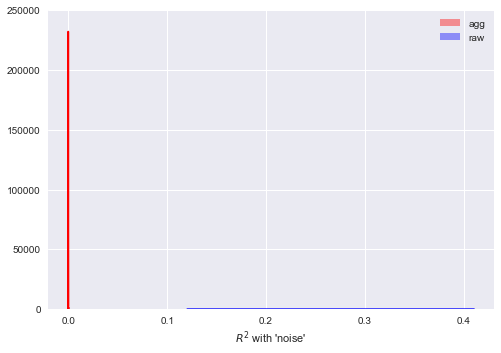

In [3]:
import seaborn as sns
sns.distplot(agg_noise_shared_variance, label="agg", color='r')
sns.distplot(orig_noise_shared_variance, label="raw", color='b')
plt.xlabel("$R^2$ with 'noise'")
plt.ylim([0, 250000])
plt.legend()

The distribution for the aggressive denoised data is very narrow and centered around zero. As predicted the aggressively denoised data has very little to do with the noise component. Let's plot this with diferrent range ov values so we could see the "raw" distribution.

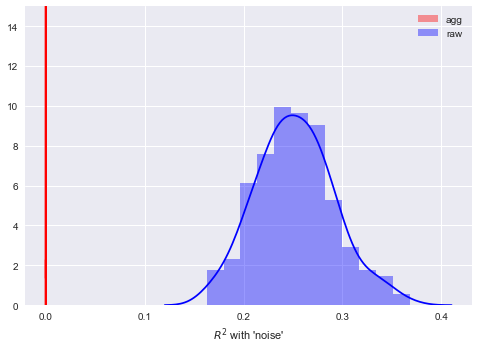

In [4]:
sns.distplot(agg_noise_shared_variance, label="agg", color='r')
sns.distplot(orig_noise_shared_variance, label="raw", color='b')
plt.xlabel("$R^2$ with 'noise'")
plt.ylim([0, 15])
plt.legend()

Ok now it's turn to look at how much variance is shared with the "signal" component. We predict that denoising will reduce the correlation of data with the "signal" component (because variance shared between "signal" and "noise" was removed), but it should not go all the way to zero. Afterall, the unique "signal" variance should not be removed.

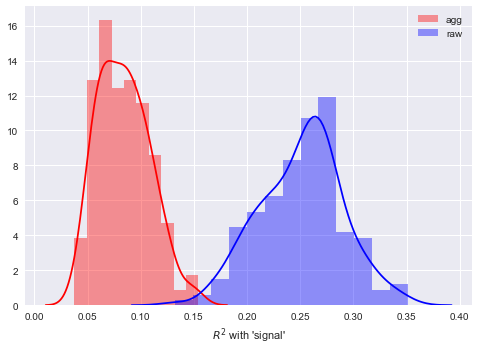

In [5]:
sns.distplot(agg_signal_shared_variance, label="agg", color='r')
sns.distplot(orig_signal_shared_variance, label="raw", color='b')
plt.xlabel("$R^2$ with 'signal'")
plt.legend()

Hypothesis confirmed! "aggressive" denoising removes some but not all "signal" related variance.

## "non-agressive" denoising
Lets repeat this for the "non-agressive" strategy. First test we will make is with regards to how much "noise" variance was removed. We hypothesise that the denoised data will have less "noise" variance than the raw data, but it will not be reduced to zero since only "unique noise variance" should be removed.

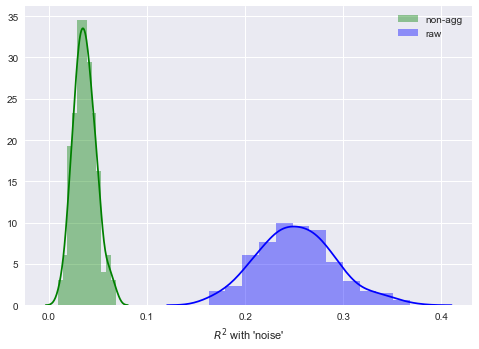

In [6]:
sns.distplot(nonagg_noise_shared_variance, label="non-agg", color='g')
sns.distplot(orig_noise_shared_variance, label="raw", color='b')
plt.xlabel("$R^2$ with 'noise'")
plt.legend()

Hypothesis confirmed!

Now's the turn to look at how much "signal" variance was removed. According to the interpretations from the quoted papers we should not see any reduction in correlation with "signal" since it

> keeps variance that is shared between components labeled as noise relative to components that are not clearly identifiable as being noise, and thus could contain signal

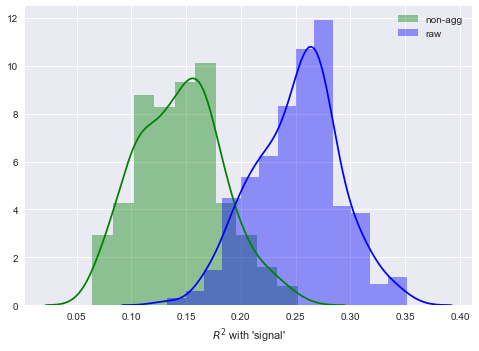

In [9]:
sns.distplot(nonagg_signal_shared_variance, label="non-agg", color='g')
sns.distplot(orig_signal_shared_variance, label="raw", color='b')
plt.xlabel("$R^2$ with 'signal'")
plt.legend()

Ups! It seems that the "non-agressive" denoising does remove at least some of the "signal" variance? How this removal compares to  "aggressive" denoising?

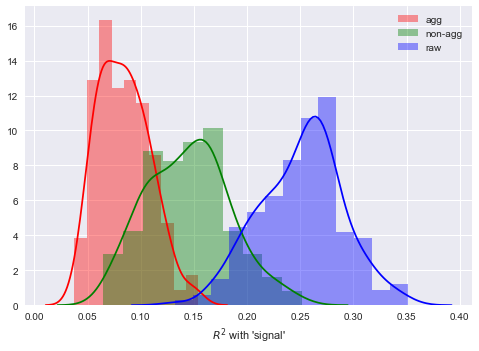

In [10]:
sns.distplot(agg_signal_shared_variance, label="agg", color='r')
sns.distplot(nonagg_signal_shared_variance, label="non-agg", color='g')
sns.distplot(orig_signal_shared_variance, label="raw", color='b')
plt.xlabel("$R^2$ with 'signal'")
plt.legend()

So the "non-aggressive" denoising removes less "signal" related variance than "aggressive" denoising, but according to interpretation it should not remove any.

## What is going on?
When both "noise" and "signal" components are entered in the GLM the estimated coefficients ("beta" values) do not correspond to unique contributions of the two components (as I mistakenly thought for many years). The linear decomposition performed by the GLM assigns some of the shared variance to one component and some to the other. The more share variance is there the higher variance of the coefficient estimates and lower p-values corresponding to them (and this is why colinearity is so bad in fMRI GLM models). The division of the shared variance falls, on average, somewhere in the middle. This is why we see the the "non-aggressive" denoising removes on average less "signal" related variance.

# Bottom line

* Does "non-aggressive" denoising remove some of the variance related to "good"/"signal" components: **Yes**
* Does "non-aggressive" denoising only removes unique "bad"/"noise" variance: **No**
* Was the math in the quoted papers wrong?: **No - just the interpretation in some of them**
* Is "non-aggrressive" denoising incorrect?: **No. It's not only correct, but has also been evaluated by independent studies. It just does not only remove unique "noise" variance.**
* Why should I care?: **I don't know!**

# Bonus - "unique noise variance" denoising
What if you would like to perform denoising that in fact does not remove any of the variance shared between "noise" and "signal" components? Would that be possible?

Yes! With the power of orthogonalization.

All we need to do is orthogonalize the "noise" component with regards to the "signal" components. In other words we will do the same thing as in the "aggressive" denoising, but we will first remove any variance shared with the "signal" component from the "noise" component. Here's the code:

In [316]:
res_beta = np.dot(noise_component.T, np.linalg.pinv(signal_component).T)
ortho_reg = noise_component - np.dot(signal_component, res_beta)
agg_res = np.dot(ortho_reg, np.dot(bold_data.T, np.linalg.pinv(ortho_reg).T))
newData_ortho = bold_data - agg_res

So how does it perform? Let's see how does do with regards to "noise" variance first:

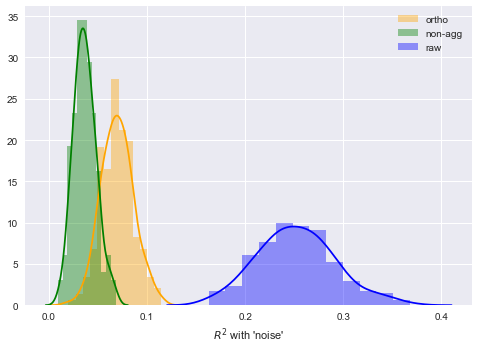

In [11]:
sns.distplot(ortho_noise_shared_variance, label="ortho", color='orange')
sns.distplot(nonagg_noise_shared_variance, label="non-agg", color='g')
sns.distplot(orig_noise_shared_variance, label="raw", color='b')
plt.xlabel("$R^2$ with 'noise'")
plt.legend()

It does remove some of the "noise" variance, but less than both "aggressive" and "non-aggressive" regressions.

Ok - what about reduction of "signal" related variance? We should see no reduction:

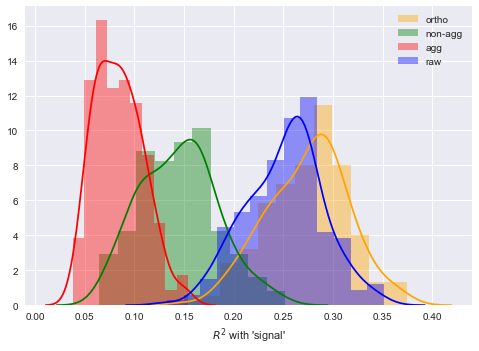

In [12]:
sns.distplot(ortho_signal_shared_variance_deltas, label="ortho", color='orange')
sns.distplot(nonagg_signal_shared_variance, label="non-agg", color='g')
sns.distplot(agg_signal_shared_variance, label="agg", color='r')
sns.distplot(orig_signal_shared_variance, label="raw", color='b')
plt.xlabel("$R^2$ with 'signal'")
plt.legend()

Not only we see no reduction in terms of correlation with the "signal" components, but we see **increased** correlation. Why is that? It's due to removal of some of the "noise" variance.

So at the end it is really a spectrum with different tradeoffs:

* The most conservative approach (I want to remove anything that has a hint of noise) would be the "aggressive" strategy
* The most liberal approach (I really do not want to throw out baby with the water) would be the "orthogonalization" strategy
* The "non-aggressive" approach lies somewhere in the middle


Below you can see a visualisation of the bivariate space of variance explained. 

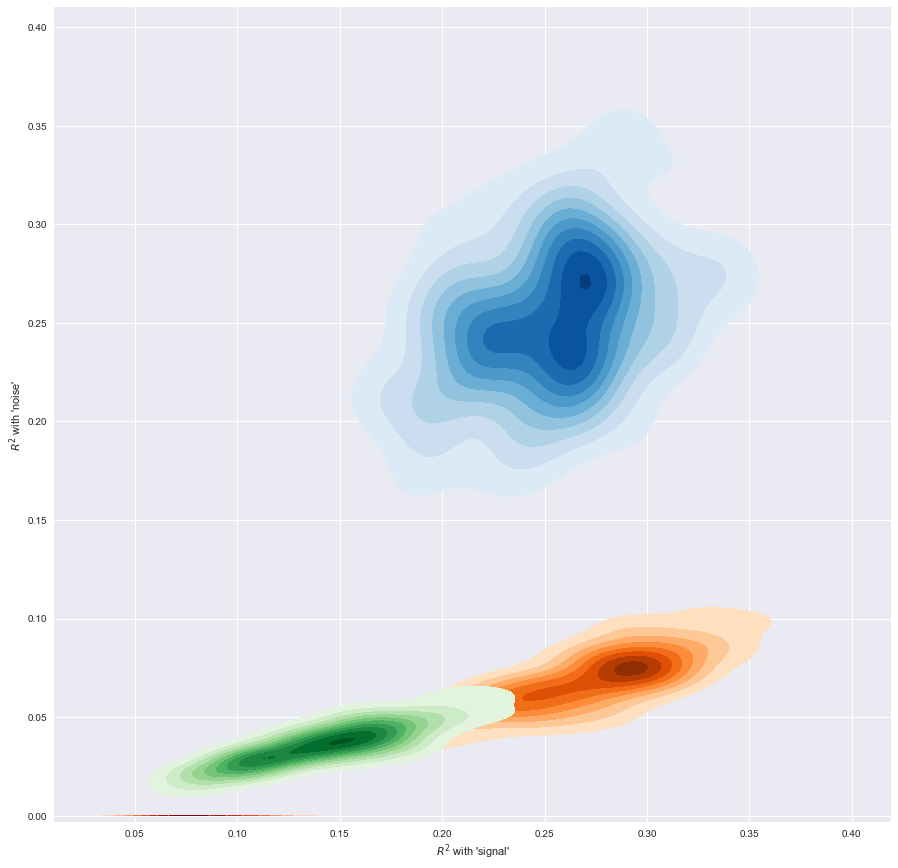

In [13]:
plt.figure(figsize=(15,15))
ax = sns.kdeplot(np.array(ortho_signal_shared_variance_deltas).ravel(), np.array(ortho_noise_shared_variance).ravel(),
                 cmap="Oranges", shade=True, shade_lowest=False)
ax = sns.kdeplot(np.array(agg_signal_shared_variance).ravel(), np.array(agg_noise_shared_variance).ravel(),
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(np.array(nonagg_signal_shared_variance).ravel(), np.array(nonagg_noise_shared_variance).ravel(),
                 cmap="Greens", shade=True, shade_lowest=False)
ax = sns.kdeplot(np.array(orig_signal_shared_variance).ravel(), np.array(orig_noise_shared_variance).ravel(),
                 cmap="Blues", shade=True, shade_lowest=False)
plt.xlabel("$R^2$ with 'signal'")
plt.ylabel("$R^2$ with 'noise'")

Did I get something wrong? Email me at: [chrisgor@stanford.edu](mailto:chrisgor@stanford.edu)